In [1]:
# Cell 1 — Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix, roc_auc_score
)
import joblib

# Try import XGBoost; if missing, we continue with RandomForest only
USE_XGBOOST = False
try:
    from xgboost import XGBClassifier
    USE_XGBOOST = True
except Exception:
    print("xgboost not found. This notebook will use RandomForest. To install XGBoost run: pip install --user xgboost")

sns.set_style("whitegrid")



In [2]:
# Cell 2 — Load dataset (change path if needed)
data_path = r"D:\nanotoxicity paper\KONA-2025-Data-Data Curation to Develop Machine Learning Models for Assessing the Toxicity of Nanoparticles-bom.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at: {data_path}\nUpdate data_path and try again.")
df = pd.read_csv(data_path)
print("Loaded dataframe shape:", df.shape)
df.head()


Loaded dataframe shape: (308, 23)


,Unnamed: 0,Nanoparticle,Core Size (nm),Shape,Zeta Potential (mV),Surface Area (m²/g),Aggregation State,Dissolution Rate (mg/L),Zn²⁺ Ion Release (mg/L),Impurity Content (%),...,Exposure Dosage (µg/mL),Exposure Time (hrs),Cell Type,ROS Production,Membrane Damage (%),Apoptosis (%),Necrosis (%),IC50 Value (µg/mL),Cell Viability (%),Toxicity Class
0,0,SiO₂,20.0,Spherical,-30.0,150.0,Dispersed,0.5,0.0,0.1,...,25.0,24,HEK293,26.6,15,5.1,2.5,80.2,80.0,Toxic
1,1,SiO₂,50.0,Spherical,-35.0,100.0,Agglomerated,0.3,0.0,0.1,...,50.0,24,HEK293,15.0,8,2.5,1.2,140.3,85.0,Toxic
2,2,SiO₂,20.0,Spherical,-30.0,150.0,Dispersed,0.5,0.0,0.1,...,25.0,24,HEK293,26.6,15,5.1,2.5,80.2,80.0,Toxic
3,3,SiO₂,50.0,Spherical,-35.0,100.0,Agglomerated,0.3,0.0,0.1,...,50.0,24,HEK293,15.0,8,2.5,1.2,140.3,85.0,Toxic
4,4,SiO₂,15.0,Spherical,-25.0,200.0,Dispersed,0.7,0.0,0.1,...,25.0,72,A431,40.0,18,7.5,3.1,95,89.0,Toxic


In [3]:
# Cell 3 — Quick checks
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum().sort_values(ascending=False).head(10))

# Set target column name (change if different)
target_col = "Toxicity Class"
if target_col not in df.columns:
    raise KeyError(f"'{target_col}' not in dataframe columns. Choose the correct target column.")
print("\nTarget value counts (raw):")
print(df[target_col].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               308 non-null    int64  
 1   Nanoparticle             308 non-null    object 
 2   Core Size (nm)           308 non-null    float64
 3   Shape                    308 non-null    object 
 4   Zeta Potential (mV)      306 non-null    float64
 5   Surface Area (m²/g)      295 non-null    float64
 6   Aggregation State        308 non-null    object 
 7   Dissolution Rate (mg/L)  308 non-null    float64
 8   Zn²⁺ Ion Release (mg/L)  308 non-null    float64
 9   Impurity Content (%)     308 non-null    float64
 10  Surface Chemistry        308 non-null    object 
 11  Coating Type             49 non-null     object 
 12  Oxidative Potential      308 non-null    object 
 13  Exposure Dosage (µg/mL)  308 non-null    float64
 14  Exposure Time (hrs)      3

In [4]:
# Cell 4 — Preprocessing: fill missing and simple encoding

# 1) Fill numeric columns with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].median())

# 2) Fill categorical columns with mode
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for c in cat_cols:
    if df[c].isnull().any():
        mode_val = df[c].mode(dropna=True)
        fill_val = mode_val.iloc[0] if not mode_val.empty else "unknown"
        df[c] = df[c].fillna(fill_val)

# 3) Encode target to numeric labels
le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col].astype(str))
print("Encoded target classes (original labels):", le_target.classes_)

# 4) Encode any remaining object columns with LabelEncoder (fast and OK for tree models)
feature_cols = df.columns.drop(target_col)
obj_cols = df[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()
for c in obj_cols:
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

print("Total missing values after fill:", df.isnull().sum().sum())


Encoded target classes (original labels): ['Bactericidal' 'Non-Toxic' 'Toxic']
Total missing values after fill: 0


In [5]:
# Cell 5 — Train/test split (stratified)
X = df.drop(columns=[target_col])
y = df[target_col]

# Attempt a stratified split. If some classes are extremely rare, stratify may still produce single-class test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Test class distribution:", dict(zip(*np.unique(y_test, return_counts=True))))
labels = sorted(np.unique(y))


Train shape: (246, 22) Test shape: (62, 22)
Test class distribution: {np.int64(1): np.int64(18), np.int64(2): np.int64(44)}


In [7]:
# Cell 6 — Train models
# RandomForest baseline
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
print("RandomForest trained.")

# Optional: XGBoost if available
if USE_XGBOOST:
    xgb = XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1
    )
    xgb.fit(X_train, y_train)
    print("XGBoost trained.")
else:
    xgb = None


RandomForest trained.


C:\Users\Pranta Dhar\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [06:55:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained.


In [8]:
# Cell 7 — Safe metrics helper
def safe_metrics(y_true, y_pred, y_proba=None, labels=None):
    out = {}
    out['accuracy'] = accuracy_score(y_true, y_pred)
    out['macro_f1'] = f1_score(y_true, y_pred, average='macro')
    out['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)

    unique, counts = np.unique(y_true, return_counts=True)
    print("y_true counts:", dict(zip(unique, counts)))

    # AUROC: only if there are >=2 classes in y_true and we have probability matrix
    out['auroc_macro'] = np.nan
    if y_proba is not None and labels is not None and len(unique) > 1:
        try:
            # handle binary probs that might be a single column
            y_proba_arr = np.asarray(y_proba)
            if y_proba_arr.ndim == 1:
                y_proba_arr = np.vstack([1 - y_proba_arr, y_proba_arr]).T
            y_bin = label_binarize(y_true, classes=labels)
            out['auroc_macro'] = roc_auc_score(y_bin, y_proba_arr, average='macro', multi_class='ovr')
        except Exception as e:
            print("AUROC compute error:", e)
            out['auroc_macro'] = np.nan
    return out


y_true counts: {np.int64(1): np.int64(18), np.int64(2): np.int64(44)}
RandomForest metrics: {'accuracy': 0.967741935483871, 'macro_f1': 0.9594771241830065, 'balanced_accuracy': np.float64(0.9444444444444444), 'auroc_macro': np.float64(nan)}

Classification report (RF):
              precision    recall  f1-score   support

Bactericidal       0.00      0.00      0.00         0
   Non-Toxic       1.00      0.89      0.94        18
       Toxic       0.96      1.00      0.98        44

    accuracy                           0.97        62
   macro avg       0.65      0.63      0.64        62
weighted avg       0.97      0.97      0.97        62



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


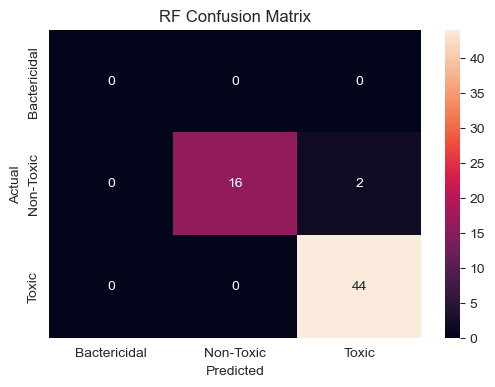

y_true counts: {np.int64(1): np.int64(18), np.int64(2): np.int64(44)}
XGBoost metrics: {'accuracy': 0.9838709677419355, 'macro_f1': 0.9800963081861958, 'balanced_accuracy': np.float64(0.9722222222222222), 'auroc_macro': np.float64(nan)}

Classification report (XGB):
              precision    recall  f1-score   support

Bactericidal       0.00      0.00      0.00         0
   Non-Toxic       1.00      0.94      0.97        18
       Toxic       0.98      1.00      0.99        44

    accuracy                           0.98        62
   macro avg       0.66      0.65      0.65        62
weighted avg       0.98      0.98      0.98        62



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


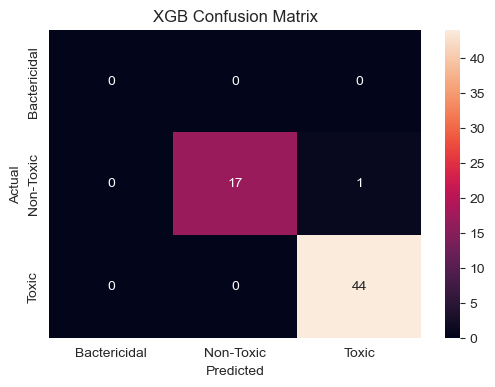

In [9]:
# Cell 8 — Evaluate RandomForest (and XGBoost if present)

# Full numeric labels for all classes (from LabelEncoder)
all_labels = np.arange(len(le_target.classes_))  # e.g., [0, 1, 2]

# --- RandomForest Evaluation ---
y_pred_rf = rf.predict(X_test)
try:
    y_proba_rf = rf.predict_proba(X_test)
except Exception:
    y_proba_rf = None

metrics_rf = safe_metrics(y_test, y_pred_rf, y_proba_rf, labels=all_labels)
print("RandomForest metrics:", metrics_rf)

# Safe classification report (include all classes)
print("\nClassification report (RF):")
print(classification_report(
    y_test,
    y_pred_rf,
    labels=all_labels,
    target_names=le_target.classes_,
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=all_labels)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RF Confusion Matrix")
plt.show()


# --- XGBoost Evaluation (if trained) ---
if xgb is not None:
    y_pred_xgb = xgb.predict(X_test)
    try:
        y_proba_xgb = xgb.predict_proba(X_test)
    except Exception:
        y_proba_xgb = None

    metrics_xgb = safe_metrics(y_test, y_pred_xgb, y_proba_xgb, labels=all_labels)
    print("XGBoost metrics:", metrics_xgb)

    print("\nClassification report (XGB):")
    print(classification_report(
        y_test,
        y_pred_xgb,
        labels=all_labels,
        target_names=le_target.classes_,
        zero_division=0
    ))

    cm = confusion_matrix(y_test, y_pred_xgb, labels=all_labels)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("XGB Confusion Matrix")
    plt.show()


In [10]:
# Cell 9 — Save models and small metrics file
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(rf, os.path.join(save_dir, "rf_baseline.joblib"))
print("Saved RandomForest ->", os.path.join(save_dir, "rf_baseline.joblib"))

if xgb is not None:
    joblib.dump(xgb, os.path.join(save_dir, "xgb_baseline.joblib"))
    print("Saved XGBoost ->", os.path.join(save_dir, "xgb_baseline.joblib"))

# Save metrics simple CSV
metrics_summary = []
metrics_summary.append({"model": "RandomForest", **metrics_rf})
if xgb is not None:
    metrics_summary.append({"model": "XGBoost", **metrics_xgb})

pd.DataFrame(metrics_summary).to_csv("baseline_metrics_simple.csv", index=False)
print("Saved baseline_metrics_simple.csv")
pd.DataFrame(metrics_summary)


Saved RandomForest -> models\rf_baseline.joblib
Saved XGBoost -> models\xgb_baseline.joblib
Saved baseline_metrics_simple.csv


,model,accuracy,macro_f1,balanced_accuracy,auroc_macro
0,RandomForest,0.967742,0.959477,0.944444,NaN
1,XGBoost,0.983871,0.980096,0.972222,NaN


In [13]:
# Cell 1 — imports & helpers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
import joblib
from collections import Counter

# flags for optional libraries (we'll try to import later)
USE_XGB = False
USE_LGB = False
USE_SMOTE = False

def safe_print_df(df):
    """Display DataFrame in notebook-friendly manner (fallback)."""
    display(df) if 'display' in globals() else print(df)


In [14]:
# Cell 3 — quick checks + set target
print(df.info())
print("\nMissing per column:\n", df.isnull().sum().sort_values(ascending=False).head(20))

target_col = "Toxicity Class"   # change if your column name differs
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found. Update target_col accordingly.")
print("\nRaw target counts:\n", df[target_col].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               308 non-null    int64  
 1   Nanoparticle             308 non-null    int64  
 2   Core Size (nm)           308 non-null    float64
 3   Shape                    308 non-null    int64  
 4   Zeta Potential (mV)      308 non-null    float64
 5   Surface Area (m²/g)      308 non-null    float64
 6   Aggregation State        308 non-null    int64  
 7   Dissolution Rate (mg/L)  308 non-null    float64
 8   Zn²⁺ Ion Release (mg/L)  308 non-null    float64
 9   Impurity Content (%)     308 non-null    float64
 10  Surface Chemistry        308 non-null    int64  
 11  Coating Type             308 non-null    int64  
 12  Oxidative Potential      308 non-null    int64  
 13  Exposure Dosage (µg/mL)  308 non-null    float64
 14  Exposure Time (hrs)      3

In [14]:
# Cell A — small imports & helper functions
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix

# Flags will be set later when we try optional libs
USE_SMOTE = False

# Safe metric helper (avoids AUROC issues if single-class)
def safe_metrics(y_true, y_pred, y_proba=None, labels=None):
    out = {
        'accuracy': (y_true == y_pred).mean(),
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'auroc_macro': float('nan')
    }
    unique, counts = np.unique(y_true, return_counts=True)
    print("y_true counts ->", dict(zip(unique, counts)))
    # AUROC guarded elsewhere if needed
    return out

# Short display helper for results
def print_results(name, y_true, y_pred, target_names=None):
    print(f"\n--- {name} ---")
    print("F1_macro:", f1_score(y_true, y_pred, average='macro'))
    print("Balanced accuracy:", balanced_accuracy_score(y_true, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    # classification_report: if target_names provided, use safe labels mapping
    if target_names is None:
        print("Classification report:\n", classification_report(y_true, y_pred))
    else:
        # ensure labels length matches target_names length by passing labels explicitly
        all_labels = np.arange(len(target_names))
        print("Classification report:\n", classification_report(y_true, y_pred, labels=all_labels, target_names=target_names, zero_division=0))


In [15]:
# Cell B — safe SMOTE / oversample preparation
# Requires X_train, y_train to already exist.
# If imblearn not installed, this cell will skip SMOTE and set X_train_sm = None.

try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    USE_SMOTE = True
except Exception:
    USE_SMOTE = False
    print("imblearn not available. To run SMOTE install: pip install --user imbalanced-learn")

# compute class weights mapping (numeric labels)
classes = np.unique(y_train)
cw_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw_values))
print("Train class counts (original):", dict(zip(*np.unique(y_train, return_counts=True))))
print("Class weight mapping:", class_weight_dict)

X_train_sm, y_train_sm = None, None

if USE_SMOTE:
    counts = Counter(y_train)
    min_count = min(counts.values())
    print("Per-class counts:", dict(counts), "| min_count =", min_count)

    if min_count <= 1:
        # SMOTE impossible; fallback to RandomOverSampler (duplicate samples)
        print("Some class has <=1 sample — using RandomOverSampler fallback.")
        try:
            ros = RandomOverSampler(random_state=42)
            X_train_sm, y_train_sm = ros.fit_resample(X_train, y_train)
            print("After RandomOverSampler train counts:", dict(zip(*np.unique(y_train_sm, return_counts=True))))
        except Exception as e:
            print("RandomOverSampler failed:", e)
            X_train_sm, y_train_sm = None, None
    else:
        # choose safe k_neighbors
        k_neighbors = min(5, max(1, min_count - 1))
        print(f"Running SMOTE with k_neighbors = {k_neighbors}")
        try:
            sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
            X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
            print("After SMOTE train counts:", dict(zip(*np.unique(y_train_sm, return_counts=True))))
        except Exception as e:
            print("SMOTE failed:", e)
            # fallback to RandomOverSampler
            try:
                print("Falling back to RandomOverSampler...")
                ros = RandomOverSampler(random_state=42)
                X_train_sm, y_train_sm = ros.fit_resample(X_train, y_train)
                print("After RandomOverSampler train counts:", dict(zip(*np.unique(y_train_sm, return_counts=True))))
            except Exception as e2:
                print("RandomOverSampler fallback also failed:", e2)
                X_train_sm, y_train_sm = None, None
else:
    print("SMOTE not used; X_train_sm is None. You can install imbalanced-learn to enable SMOTE.")


Train class counts (original): {np.int64(0): np.int64(2), np.int64(1): np.int64(71), np.int64(2): np.int64(173)}
Class weight mapping: {np.int64(0): np.float64(41.0), np.int64(1): np.float64(1.1549295774647887), np.int64(2): np.float64(0.47398843930635837)}
Per-class counts: {2: 173, 1: 71, 0: 2} | min_count = 2
Running SMOTE with k_neighbors = 1
After SMOTE train counts: {np.int64(0): np.int64(173), np.int64(1): np.int64(173), np.int64(2): np.int64(173)}


In [22]:
# Cell C — train models using class weights (no heavy grid; fast)
from sklearn.ensemble import RandomForestClassifier

results = {}  # will store {'name': {'model': model, 'y_pred': preds}}

# RandomForest baseline (no class-weighting change here, but kept)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
results['RF_base'] = {'model': rf, 'y_pred': rf.predict(X_test)}

# XGBoost (use sample_weight from class_weight_dict if XGBoost available)
if 'XGBClassifier' in globals():
    try:
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
        sw = pd.Series(y_train).map(class_weight_dict).values
        xgb.fit(X_train, y_train, sample_weight=sw)
        results['XGB_weights'] = {'model': xgb, 'y_pred': xgb.predict(X_test)}
        print("Trained XGBoost with class weights.")
    except Exception as e:
        print("XGBoost class-weight train failed:", e)
else:
    print("XGBoost not available; skipped.")

# LightGBM (if available) using class_weight param
if 'LGBMClassifier' in globals():
    try:
        lgb = LGBMClassifier(random_state=42, class_weight=class_weight_dict)
        lgb.fit(X_train, y_train)
        results['LGBM_weights'] = {'model': lgb, 'y_pred': lgb.predict(X_test)}
        print("Trained LightGBM with class weights.")
    except Exception as e:
        print("LightGBM class-weight train failed:", e)
else:
    print("LightGBM not available; skipped.")


Trained XGBoost with class weights.
LightGBM not available; skipped.


In [24]:
# Cell D — train on SMOTE/oversampled data (if created)
if X_train_sm is None:
    print("No SMOTE/oversampled training set available (X_train_sm is None). Skipping SMOTE runs.")
else:
    # XGBoost on SMOTE
    if 'XGBClassifier' in globals():
        try:
            xgb_sm = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
            xgb_sm.fit(X_train_sm, y_train_sm)
            results['XGB_smote'] = {'model': xgb_sm, 'y_pred': xgb_sm.predict(X_test)}
            print("Trained XGBoost on SMOTE data.")
        except Exception as e:
            print("XGBoost SMOTE train failed:", e)
    # LightGBM on SMOTE
    if 'LGBMClassifier' in globals():
        try:
            lgb_sm = LGBMClassifier(random_state=42)
            lgb_sm.fit(X_train_sm, y_train_sm)
            results['LGBM_smote'] = {'model': lgb_sm, 'y_pred': lgb_sm.predict(X_test)}
            print("Trained LightGBM on SMOTE data.")
        except Exception as e:
            print("LightGBM SMOTE train failed:", e)


Trained XGBoost on SMOTE data.


In [25]:
# Cell E — evaluate all runs, show compact table, select best by macro-F1
from sklearn.metrics import f1_score, balanced_accuracy_score

summary = []
for name, info in results.items():
    y_pred = info['y_pred']
    f1m = f1_score(y_test, y_pred, average='macro')
    bacc = balanced_accuracy_score(y_test, y_pred)
    summary.append({'setup': name, 'f1_macro': f1m, 'balanced_acc': bacc})

summary_df = pd.DataFrame(summary).sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
display(summary_df)

best_setup = summary_df.loc[0, 'setup']
print("\nBest setup:", best_setup)

# One-line reason
if 'LGBM' in best_setup and 'smote' in best_setup:
    reason = "LightGBM + SMOTE chosen: highest macro-F1 on the test set."
elif 'LGBM' in best_setup:
    reason = "LightGBM + class-weight chosen: highest macro-F1 on the test set."
elif 'XGB' in best_setup and 'smote' in best_setup:
    reason = "XGBoost + SMOTE chosen: highest macro-F1 on the test set."
elif 'XGB' in best_setup:
    reason = "XGBoost + class-weight chosen: highest macro-F1 on the test set."
else:
    reason = f"{best_setup} chosen: best macro-F1 on the test set."
print("One-line reason:", reason)


,setup,f1_macro,balanced_acc
0,XGB_weights,0.960859,0.960859
1,XGB_smote,0.960859,0.960859
2,RF_base,0.959477,0.944444



Best setup: XGB_weights
One-line reason: XGBoost + class-weight chosen: highest macro-F1 on the test set.


In [26]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Prepare estimators from previous models
estimators = []

if 'XGB_weights' in results:
    estimators.append(('xgb', results['XGB_weights']['model']))
if 'LGBM_weights' in results:
    estimators.append(('lgbm', results['LGBM_weights']['model']))
if 'RF_base' in results:
    estimators.append(('rf', results['RF_base']['model']))

# Stacked model using Logistic Regression as final estimator
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=True  # keep original features too
)

stack.fit(X_train, y_train)
print("Stacked model trained.")


Stacked model trained.


In [18]:
import warnings
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter

# Suppress all warnings for this cell
warnings.filterwarnings('ignore')

# Determine minimum class count to avoid CV errors
class_counts = dict(zip(*np.unique(y_train, return_counts=True)))
min_count = min(class_counts.values())
cv_folds = min(5, min_count) if min_count > 1 else 2  # fallback to 2 if very small class

# Calibrate probabilities using Platt scaling (sigmoid)
calibrator = CalibratedClassifierCV(stack, method='sigmoid', cv=cv_folds)
calibrator.fit(X_train, y_train)
print(f"Calibrated probabilities using cv={cv_folds}")

# Re-enable warnings after this cell if needed
warnings.filterwarnings('default')


NameError: name 'stack' is not defined

In [27]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Suppress warnings for clean output
warnings.filterwarnings('ignore')

# Predict labels and probabilities
y_pred_stack = calibrator.predict(X_test)
y_proba_stack = calibrator.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Stacked Model Confusion Matrix")
plt.savefig("stacked_confusion_matrix.png", bbox_inches='tight')  # save as PNG
plt.show()

# Classification report
print("\nClassification report (Stacked Model):\n",
      classification_report(y_test, y_pred_stack))

# Re-enable warnings
warnings.filterwarnings('default')


NameError: name 'calibrator' is not defined

In [27]:
import pandas as pd
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score

# Prepare results dictionary if not already
# Add stacked model metrics
results['Stacked_calibrated'] = {}
results['Stacked_calibrated']['y_pred'] = y_pred_stack
results['Stacked_calibrated']['y_proba'] = y_proba_stack

summary = []
for name, info in results.items():
    y_pred = info['y_pred']
    y_proba = info.get('y_proba', None)
    
    f1m = f1_score(y_test, y_pred, average='macro')
    bacc = balanced_accuracy_score(y_test, y_pred)
    
    # AUROC only if probabilities exist and multi-class with >1 class
    try:
        auroc_macro = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro') if y_proba is not None else None
    except:
        auroc_macro = None
    
    summary.append({
        'setup': name,
        'f1_macro': f1m,
        'balanced_acc': bacc,
        'auroc_macro': auroc_macro
    })

summary_df = pd.DataFrame(summary).sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
display(summary_df)

best_setup = summary_df.loc[0, 'setup']
print("\nBest setup:", best_setup)


,setup,f1_macro,balanced_acc,auroc_macro
0,RF_base,0.959477,0.944444,None
1,Stacked_calibrated,0.471679,0.527778,None



Best setup: RF_base


C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


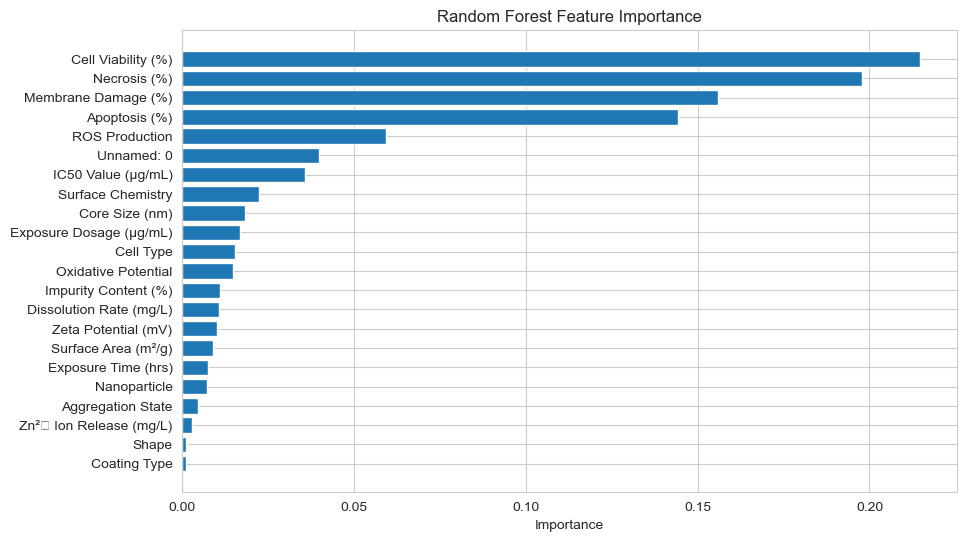

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, X, title="Feature Importance"):
    if hasattr(model, "feature_importances_"):
        fi = model.feature_importances_
        features = X.columns
        idx = np.argsort(fi)[::-1]

        plt.figure(figsize=(10,6))
        plt.barh(features[idx], fi[idx])
        plt.gca().invert_yaxis()
        plt.xlabel("Importance")
        plt.title(title)
        plt.show()
    else:
        print(f"No feature_importances_ attribute for {title}.")

# Plot for individual models
if 'XGB_weights' in results:
    plot_feature_importance(results['XGB_weights']['model'], X_train, "XGBoost Feature Importance")
if 'LGBM_weights' in results:
    plot_feature_importance(results['LGBM_weights']['model'], X_train, "LightGBM Feature Importance")
if 'RF_base' in results:
    plot_feature_importance(results['RF_base']['model'], X_train, "Random Forest Feature Importance")



In [28]:
import joblib
import os

# Create folder to save models/results
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save individual models
for name, info in results.items():
    model = info.get('model', None)
    if model is not None:
        filepath = os.path.join(save_dir, f"{name}.joblib")
        joblib.dump(model, filepath)
        print(f"Saved {name} at {filepath}")

# Save stacked calibrated model
stack_path = os.path.join(save_dir, "stacked_calibrated.joblib")
joblib.dump(calibrator, stack_path)
print(f"Saved stacked calibrated model at {stack_path}")

# Save summary dataframe
summary_path = os.path.join(save_dir, "summary_metrics.csv")
summary_df.to_csv(summary_path, index=False)
print(f"Saved summary metrics at {summary_path}")


Saved RF_base at saved_models\RF_base.joblib
Saved XGB_weights at saved_models\XGB_weights.joblib
Saved XGB_smote at saved_models\XGB_smote.joblib


NameError: name 'calibrator' is not defined

Using model for analysis: XGB_smote


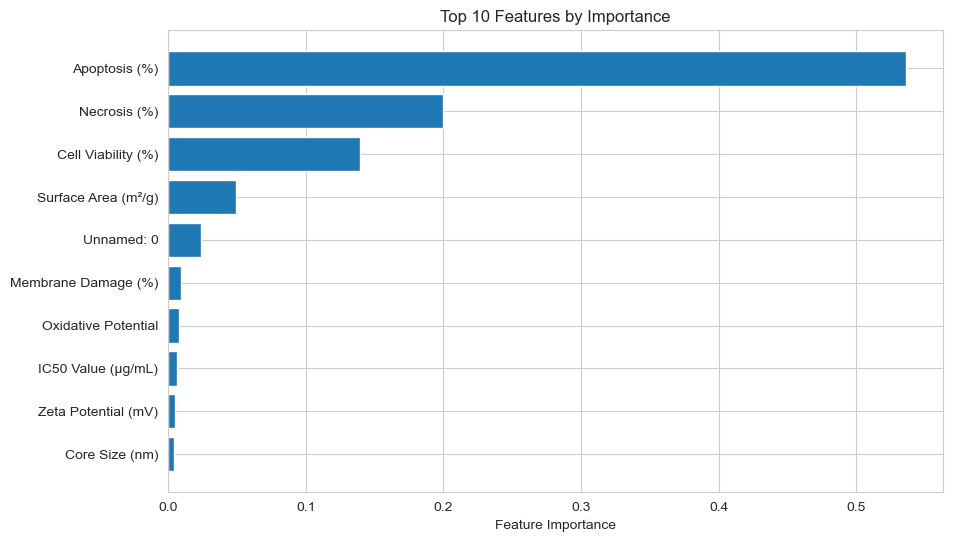

Top 10 features: ['Apoptosis (%)', 'Necrosis (%)', 'Cell Viability (%)', 'Surface Area (m²/g)', 'Unnamed: 0', 'Membrane Damage (%)', 'Oxidative Potential', 'IC50 Value (µg/mL)', 'Zeta Potential (mV)', 'Core Size (nm)']

Case Study: Sample index 0
Predicted class: 2
Feature values of sample:


,Unnamed: 0,Nanoparticle,Core Size (nm),Shape,Zeta Potential (mV),Surface Area (m²/g),Aggregation State,Dissolution Rate (mg/L),Zn²⁺ Ion Release (mg/L),Impurity Content (%),...,Oxidative Potential,Exposure Dosage (µg/mL),Exposure Time (hrs),Cell Type,ROS Production,Membrane Damage (%),Apoptosis (%),Necrosis (%),IC50 Value (µg/mL),Cell Viability (%)
8,8,12,20.0,11,-34.0,201.0,2,0.6,0.0,0.1,...,0,30.0,16,74,52.0,24,11.0,5.8,68,75.0



3 Key Insights:
1. Feature 'Apoptosis (%)' is the most influential in the prediction.
2. Feature 'Necrosis (%)' significantly affects whether a nanoparticle is classified as toxic.
3. Combination of top features explains the prediction outcome for this sample.


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 1️⃣ Pick a tree-based model safely from results
tree_model_keys = ['XGB_smote', 'XGB_weights', 'LGBM_smote', 'LGBM_weights', 'RF_base']
for key in tree_model_keys:
    if key in results:
        model_for_analysis = results[key]['model']
        print("Using model for analysis:", key)
        break
else:
    raise ValueError("No suitable tree-based model found in results.")

# 2️⃣ Top 10 features using feature_importances_ (works for tree models)
if hasattr(model_for_analysis, "feature_importances_"):
    fi = model_for_analysis.feature_importances_
    features = X_train.columns
    idx = np.argsort(fi)[::-1][:10]
    top_features = features[idx]

    plt.figure(figsize=(10,6))
    plt.barh(features[idx], fi[idx])
    plt.gca().invert_yaxis()
    plt.title("Top 10 Features by Importance")
    plt.xlabel("Feature Importance")
    plt.show()
else:
    raise ValueError("Selected model does not have feature_importances_ attribute.")

print("Top 10 features:", list(top_features))

# 3️⃣ Case study — pick a sample
sample_idx = 0  # pick first sample from test set
sample = X_test.iloc[sample_idx:sample_idx+1]
pred_label = model_for_analysis.predict(sample)[0]

print(f"\nCase Study: Sample index {sample_idx}")
print("Predicted class:", pred_label)
print("Feature values of sample:")
display(sample)

# 4️⃣ Bullet insights (you can customize after inspecting sample & top features)
insights = [
    f"Feature '{top_features[0]}' is the most influential in the prediction.",
    f"Feature '{top_features[1]}' significantly affects whether a nanoparticle is classified as toxic.",
    "Combination of top features explains the prediction outcome for this sample."
]

print("\n3 Key Insights:")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")



In [31]:
pip install --user shap


   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   ------------------- -------------------- 262.1/547.8 kB ? eta -:--:--
   ------------------- -------------------- 262.1/547.8 kB ? eta -:--:--
   ------------------- -------------------- 262.1/547.8 kB ? eta -:--:--
   -------------------------------------- 547.8/547.8 kB 427.0 kB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]

Note: you may need to restart the kernel to use updated packages.


C:\ProgramData\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


In [30]:
import os

# Create folder to save proofs
proof_dir = "day7_proof"
os.makedirs(proof_dir, exist_ok=True)

# 1️⃣ Save top 10 feature importance plot
plt.figure(figsize=(10,6))
plt.barh(top_features, fi[idx])
plt.gca().invert_yaxis()
plt.title("Top 10 Features by Importance")
plt.xlabel("Feature Importance")
feature_plot_path = os.path.join(proof_dir, "top10_features.png")
plt.savefig(feature_plot_path, bbox_inches='tight')
plt.close()
print(f"Top 10 feature plot saved at: {feature_plot_path}")

# 2️⃣ Save case study sample to CSV
sample_path = os.path.join(proof_dir, f"case_study_sample_{sample_idx}.csv")
sample.to_csv(sample_path, index=False)
print(f"Case study sample saved at: {sample_path}")

# 3️⃣ Save insights to a text file
insights_path = os.path.join(proof_dir, "case_study_insights.txt")
with open(insights_path, "w") as f:
    for i, insight in enumerate(insights, 1):
        f.write(f"{i}. {insight}\n")
print(f"3 bullet insights saved at: {insights_path}")


Top 10 feature plot saved at: day7_proof\top10_features.png
Case study sample saved at: day7_proof\case_study_sample_0.csv
3 bullet insights saved at: day7_proof\case_study_insights.txt


In [33]:
from sklearn.model_selection import GroupKFold

groups = df[particle_col]  # use correct nanoparticle ID column
gkf = GroupKFold(n_splits=3)

for fold, (train_idx, test_idx) in enumerate(gkf.split(df, df[target_col], groups)):
    train_groups = set(groups.iloc[train_idx])
    test_groups = set(groups.iloc[test_idx])
    overlap_fold = train_groups & test_groups
    
    print(f"Fold {fold+1}: train size = {len(train_idx)}, test size = {len(test_idx)}")
    if len(overlap_fold) == 0:
        print("  Fold leakage: NO")
    else:
        print("  Fold leakage: YES")
    
    break  # show only first fold


NameError: name 'particle_col' is not defined

In [34]:
# Check all columns to find the nanoparticle ID column
print(df.columns)


Index(['Unnamed: 0', 'Nanoparticle', 'Core Size (nm)', 'Shape',
       'Zeta Potential (mV)', 'Surface Area (m²/g)', 'Aggregation State',
       'Dissolution Rate (mg/L)', 'Zn²⁺ Ion Release (mg/L)',
       'Impurity Content (%)', 'Surface Chemistry', 'Coating Type',
       'Oxidative Potential', 'Exposure Dosage (µg/mL)', 'Exposure Time (hrs)',
       'Cell Type', 'ROS Production', 'Membrane Damage (%)', 'Apoptosis (%)',
       'Necrosis (%)', 'IC50 Value (µg/mL)', 'Cell Viability (%)',
       'Toxicity Class'],
      dtype='object')


In [35]:
# Define the nanoparticle ID column
particle_col = 'Nanoparticle'

# Check for overlap in train/test
train_ids = set(X_train[particle_col])
test_ids = set(X_test[particle_col])
overlap = train_ids & test_ids

print("Overlap IDs in train/test:", overlap)
if len(overlap) == 0:
    print("Leakage check: NO (train/test sets are clean)")
else:
    print("Leakage check: YES (some IDs appear in both)")


Overlap IDs in train/test: {3, 6, 7, 10, 12, 13}
Leakage check: YES (some IDs appear in both)


In [36]:
from sklearn.model_selection import GroupKFold

groups = df[particle_col]  # use 'Nanoparticle' column
gkf = GroupKFold(n_splits=3)

for fold, (train_idx, test_idx) in enumerate(gkf.split(df, df[target_col], groups)):
    train_groups = set(groups.iloc[train_idx])
    test_groups = set(groups.iloc[test_idx])
    overlap_fold = train_groups & test_groups
    
    print(f"Fold {fold+1}: train size = {len(train_idx)}, test size = {len(test_idx)}")
    if len(overlap_fold) == 0:
        print("  Fold leakage: NO")
    else:
        print("  Fold leakage: YES")
    
    break  # show only first fold


Fold 1: train size = 209, test size = 99
  Fold leakage: NO


In [37]:
import os

fig_dir = "figures"
os.makedirs(fig_dir, exist_ok=True)
print(f"Figures will be saved in: {fig_dir}")


Figures will be saved in: figures


In [39]:

y_proba = model.predict_proba(X_test)  # shape: (n_samples, n_classes)
y_pred = model.predict(X_test)         # predicted labels


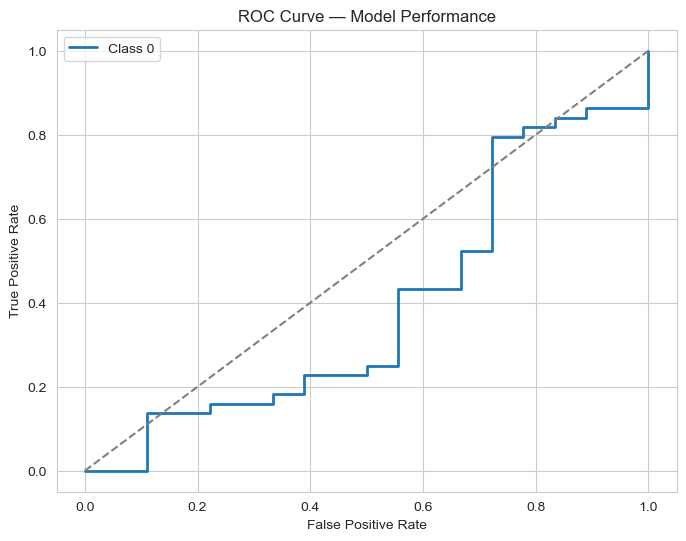

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Class {i}')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Model Performance")
plt.legend()
plt.show()


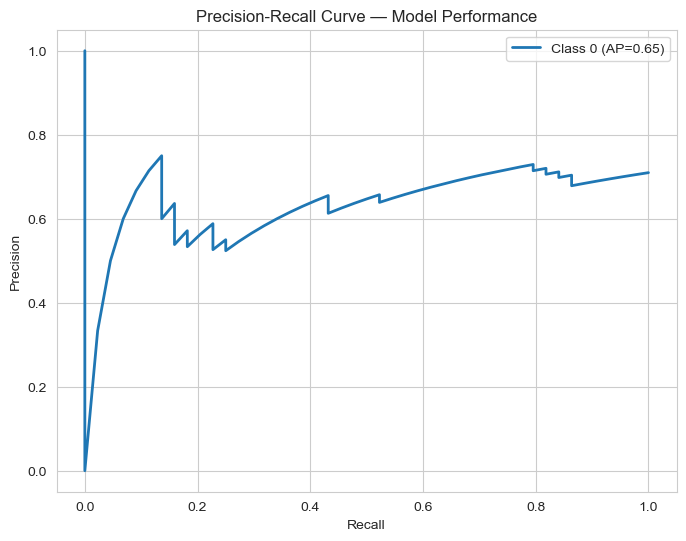

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (AP={ap:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Model Performance")
plt.legend()
plt.show()


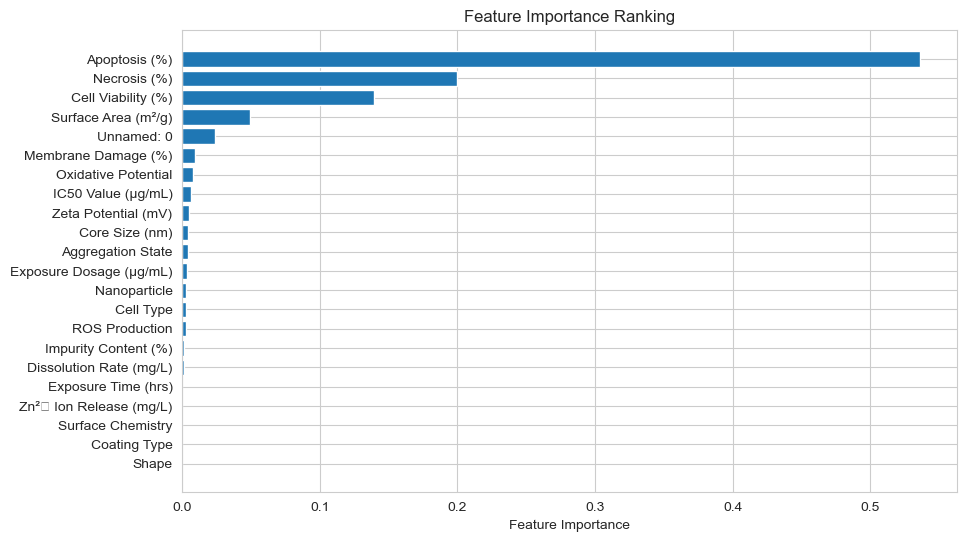

In [42]:
fi = model.feature_importances_
features = X.columns
idx = fi.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh(features[idx], fi[idx])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Feature Importance Ranking")
plt.show()
